In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
from utils import getMolFromSmile, SmilesToDescriptors
import seaborn as sns


In [2]:
df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


In [3]:
df['ee_R'].quantile(0.99)

74.10400077819826

In [4]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['curated_catalyst_2'].unique()

print(f'Total combination count: {len(reactant_1_pool) * len(catalyst_1_pool) * len(catalyst_2_pool)} (size of the dataset:{len(df)})')

Total combination count: 1430 (size of the dataset:1430)


Morgan fingerprints


In [5]:
reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan')

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='curated_catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,§
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

lookup = df[['reactant_1', 'catalyst_1', 'curated_catalyst_2', 'ee_R']]
lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,curated_catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...,0.63
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...,44.66


In [ ]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

botorch_rdm_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

fps_recommender = FPSRecommender()
random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)
botorch_rdm_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_rdm_recommender)

fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=fps_recommender)
random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"Botorch FPS": botorch_fps_campaign,"Botorch rdm": botorch_rdm_campaign, "Random": random_campaign, "FPS": fps_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

In [14]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,ee_R_IterBest,ee_R_CumBest
0,Botorch FPS,0,0,1,[-13.630000114440918],-13.630000,-13.630000
1,Botorch FPS,0,1,2,[33.119998931884766],33.119999,33.119999
2,Botorch FPS,0,2,3,[-8.460000038146973],-8.460000,33.119999
3,Botorch FPS,0,3,4,[44.22999954223633],44.230000,44.230000
4,Botorch FPS,0,4,5,[-6.670000076293945],-6.670000,44.230000
...,...,...,...,...,...,...,...
1095,FPS,4,95,96,[58.86000061035156],58.860001,79.949997
1096,FPS,4,96,97,[-7.929999828338623],-7.930000,79.949997
1097,FPS,4,97,98,[47.18999862670898],47.189999,79.949997
1098,FPS,4,98,99,[-15.729999542236328],-15.730000,79.949997


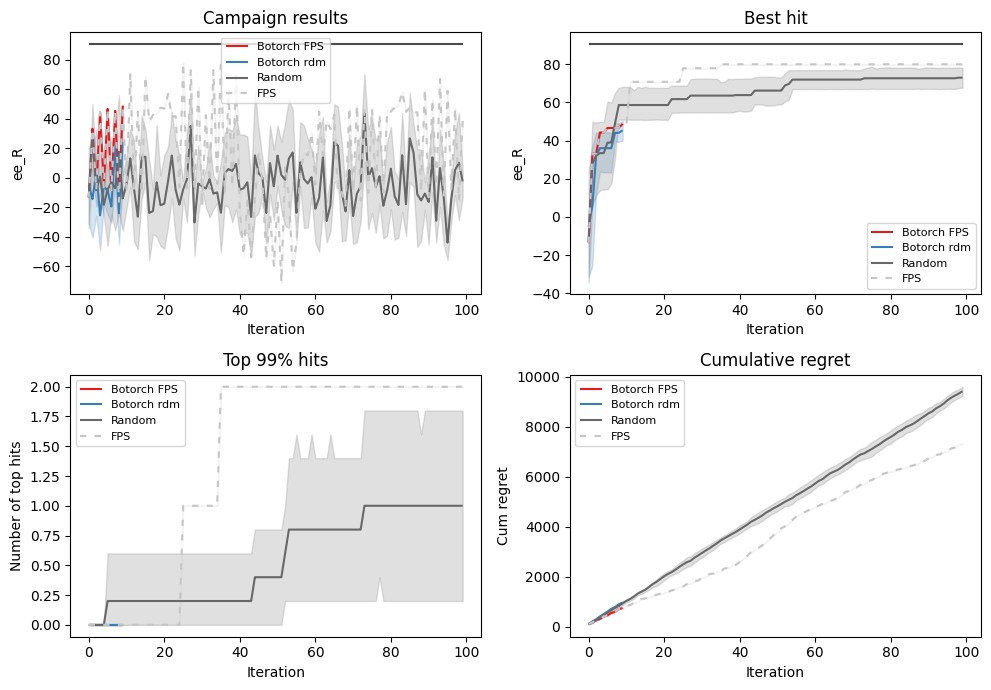

In [15]:
from utils import plot_results

plot_results(results, lookup, figure_name= 'init_bo.png', nbr_controls=2)


In [6]:
reactant_1_descriptors_rdkit = SmilesToDescriptors(reactant_1_pool, method='RDK')
catalyst_1_descriptors_rdkit = SmilesToDescriptors(catalyst_1_pool, method='RDK')
catalyst_2_descriptors_rdkit = SmilesToDescriptors(catalyst_2_pool, method='RDK')

reactant_1_descriptors_rdkit.head(3)

,0,1,5,10,16,18,19,20,27,39,...,2007,2015,2017,2019,2026,2027,2032,2037,2038,2040
c1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cc1ccc(C(=O)CBr)cc1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors_rdkit,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors_rdkit,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='curated_catalyst_2',
    data=catalyst_2_descriptors_rdkit,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

lookup = df[['reactant_1', 'catalyst_1', 'curated_catalyst_2', 'ee_R']]
lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,curated_catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...,0.63
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...,44.66


In [ ]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

botorch_rdm_recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )

fps_recommender = FPSRecommender()
random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)
botorch_rdm_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_rdm_recommender)

fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=fps_recommender)
random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"Botorch FPS": botorch_fps_campaign,"Botorch rdm": botorch_rdm_campaign, "Random": random_campaign, "FPS": fps_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

In [7]:
reactant_1_descriptors_EState = SmilesToDescriptors(reactant_1_pool, method='EState')
catalyst_1_descriptors_EState = SmilesToDescriptors(catalyst_1_pool, method='EState')
catalyst_2_descriptors_EState = SmilesToDescriptors(catalyst_2_pool, method='EState') 


reactant_1_descriptors_EState.head(3)


,EState_7,EState_9,EState_12,EState_16,EState_17,EState_19,EState_34,EState_35,EState_36,EState_38,EState_54,EState_70,TPSA,logP
c1ccc(C(=O)CBr)cc1,0.00000,0.399815,9.226175,0.125556,0.763310,0.0,0.000000,10.966551,0.0,0.0,0.0,3.101926,17.07,2.26420
Cc1ccc(C(=O)CBr)cc1,2.00237,0.398870,7.573056,0.129630,1.947775,0.0,0.000000,11.077851,0.0,0.0,0.0,3.120448,17.07,2.57262
Oc1ccc(C(=O)CBr)cc1,0.00000,0.317237,6.184167,0.018519,0.787775,0.0,8.888136,10.996218,0.0,0.0,0.0,3.057948,37.30,1.96980


In [ ]:
from baybe.parameters import CategoryParameter
from baybe.encoders   import OneHotEncoder
from baybe            import SearchSpace, Campaign

# 1. build categorical parameters
reactant_param  = CategoryParameter(
    name       = "reactant_1",
    categories = reactant_1_pool,
    encoder    = OneHotEncoder()        # <- tells BayBE to one-hot encode
)
catalyst1_param = CategoryParameter(
    name       = "catalyst_1",
    categories = catalyst_1_pool,
    encoder    = OneHotEncoder()
)
catalyst2_param = CategoryParameter(
    name       = "curated_catalyst_2",
    categories = catalyst_2_pool,
    encoder    = OneHotEncoder()
)

# 2. assemble the SearchSpace
searchspace = SearchSpace(
    parameters = {
        "reactant_1":  reactant_param,
        "catalyst_1":  catalyst1_param,
        "catalyst_2":  catalyst2_param,
    }
)

# 3. run a normal BayBE campaign
campaign = Campaign(searchspace, objective, recommender=BotorchRecommender())
